# Galaxia: Generating synthetic surveys

We make plots of mean proper motion as a function of distance from the Sun. Additionally we plot the motion of the stars in the Galactic Plane (in galactocentric coordinates) just as an additional check of understanding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
import astropy.coordinates as coord

First, we consider the full sky survey, as a check. For files named test1_*, they are contained in the file $\texttt{test1parameters}$, which is located in the /u/casey_lam/scratch directory on sloop. In particular, we try to get all stars (so magnitude limits are -1000 to 1000), we want a full sky survey (so geometryOption is set to 0), and fSample is 10${}^{-6}$ such that the computer doesn't become stupid slow. 

In [2]:
#load px, py, pz (cartesian heliocentric positions) 
HCx = np.loadtxt("test1_px") #kpc
HCy = np.loadtxt("test1_py") #kpc
HCz = np.loadtxt("test1_pz") #kpc

#load vx, vy, vz (cartesian heliocentric velocities) 
HCxvel = np.loadtxt("test1_vx") #km/s
HCyvel = np.loadtxt("test1_vy") #km/s
HCzvel = np.loadtxt("test1_vz") #km/s

#load position and velocity of sun (cartesian galactocentric coordinates)
#first three values are positions in kpc
#last three values are velocities in km/s
sun = np.loadtxt("test1_center") 

#convert from heliocentric to galactocentric coordinates
GCx = HCx + sun[0]
GCy = HCy + sun[1]
GCz = HCz + sun[2]
GCxvel = HCxvel + sun[3]
GCyvel = HCyvel + sun[4]
GCzvel = HCzvel + sun[5]

We also consider a small patch in the line of sight to OGLE-2017-BLG-0019. For files named testLOS_*, they are contained in the file $\texttt{testLOSparameters}$, which is also located in /u/casey_lam/scratch. Here, we are considering the line of sight to a particular OGLE event, OGLE-2017-BLG-0019. Again we want all stars, so magnitude limits are -1000 to 1000, the patch of sky is OGLE's field of view (35' x 35' = 0.34 deg${}^2$) so the surveyArea is set to 0.34. (The first time I ran this, I left fSample = 1 since I figured it wouldn't be that many stars... it ended up making 155 million stars, so I reran it with an fSample = 10${}^{-4}$.)

Below are the coordinates for OGLE-2017-BLG-0019:

RA (J2000.0):17:52:18.74

Dec (J2000.0):-33:00:04.0

Converting into degrees: 

17 hours 52 minutes 18.74 seconds =  (17 + (52/60) + (18.74/3600))*15  deg = 268.078083 deg

-33 degrees 00 minutes 04 seconds = -(33 + (4/3600)) deg =  -33.00111 deg

In [3]:
#convert from RA and Dec to l and b
#b is latitude, l is longitude
c = coord.SkyCoord(ra = [268.078083]*u.degree, dec = [-33.00111]*u.degree, frame='icrs')
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    [( 357.2501853, -3.32067552)]>

In [4]:
#load px, py, pz (cartesian heliocentric positions) 
HCxOGLE = np.loadtxt("testLOS_px") #kpc
HCyOGLE = np.loadtxt("testLOS_py") #kpc
HCzOGLE = np.loadtxt("testLOS_pz") #kpc

#load vx, vy, vz (cartesian heliocentric velocities) 
HCxvelOGLE = np.loadtxt("testLOS_vx") #km/s
HCyvelOGLE = np.loadtxt("testLOS_vy") #km/s
HCzvelOGLE = np.loadtxt("testLOS_vz") #km/s

#load position and velocity of sun (cartesian galactocentric coordinates)
#first three values are positions in kpc
#last three values are velocities in km/s
sunOGLE = np.loadtxt("testLOS_center") 

#convert from heliocentric to galactocentric coordinates
GCxOGLE = HCxOGLE + sunOGLE[0]
GCyOGLE = HCyOGLE + sunOGLE[1]
GCzOGLE = HCzOGLE + sunOGLE[2]
GCxvelOGLE = HCxvelOGLE + sunOGLE[3]
GCyvelOGLE = HCyvelOGLE + sunOGLE[4]
GCzvelOGLE = HCzvelOGLE + sunOGLE[5]

We are given positions and velocities in Cartesian coordinates
\begin{equation*}
    \vec{r} = (x, y, z), \quad \vec{v} = (v_x, v_y, v_z).
\end{equation*}
To match \texttt{Galaxia}, the coordinate system here is a right-handed heliocentric/galactic coordinate system, with the origin at the Sun. For the x-axis, increasing $x$ is defined as going from the Sun towards the Galactic Center, and for the z-axis, increasing $z$ is defined as going toward the North Galactic Pole. (The y-axis defined via $\hat{x} \times \hat{y} = \hat{z}$.)

The velocity can be broken up into two pieces, a transverse and radial piece,
\begin{equation*}
    \vec{v} = \vec{v}_T + \vec{v}_R.
\end{equation*}
The radial velocity $\vec{v}_R$ is the velocity in the direction of our line of sight, while the transverse velocity $\vec{v}_T$ is perpendicular to the line of sight. To calculate the radial velocity, we take the projection of the velocity vector onto the position vector, i.e. the dot product, in the radial direction
\begin{equation*}
    \vec{v}_R = (\vec{v} \cdot \hat{r}) \hat{r}
\end{equation*}
where 
\begin{equation*}
    \hat{r} \equiv \frac{\vec{r}}{|\vec{r}|} \equiv \frac{\vec{r}}{r}.
\end{equation*}
Additionally, 
\begin{equation*}
    v_T = 4.74 \mu r
\end{equation*}
where $\vec{v}_T$ is in km/s, $\mu$ is in mas/year, and $r$ is in kpc. 
Putting this all together, the proper motion in mas/year is
\begin{equation*}
    \mu = \frac{|\vec{v} - (\vec{v} \cdot \hat{r}) \hat{r}|}{4.74r}
\end{equation*}
where velocities are in km/s and distances are in kpc.

In [5]:
def plot_pm(x, y, z, xvel, yvel, zvel, binwidth):
    nstars = len(x)
    print('Number of stars:', nstars)

    radius_vec = np.array([x, y, z])
    velocity_vec = np.array([xvel, yvel, zvel])
    radius = np.linalg.norm(radius_vec, axis = 0) #same as radius = np.sqrt(HCx**2 + HCy**2 + HCz**2)
    r_hat = radius_vec/radius
    v_dot_r_hat = np.sum(velocity_vec * r_hat, axis = 0)
    pm = np.linalg.norm(velocity_vec - v_dot_r_hat * r_hat, axis = 0)/(4.74 * radius)

    dr = binwidth
    rbins = np.arange(0, 20, dr)
    averagemotion = np.zeros(len(rbins), dtype=float)
    veldispersion = np.zeros(len(rbins), dtype=float)

    for i in range(len(rbins)):
        propermotions = pm[(radius > rbins[i]) & (radius <= rbins[i] + dr)]
        if len(propermotions) == 0:
            averagemotion[i] = 'nan' #0
            veldispersion[i] = 'nan' #0
        else:
            averagemotion[i] = np.mean(propermotions)
            veldispersion[i] = np.std(propermotions)
    radialdist = rbins + dr/2.0

    plt.plot(radialdist, averagemotion, '.')
    plt.fill_between(radialdist, averagemotion-veldispersion, averagemotion+veldispersion, alpha=0.2, color='red')
    plt.xlim(0, 12)
    plt.xlabel("Distance from Sun (kpc)")
    plt.ylabel("Mean proper Motion (mas/year)")
    plt.title("Mean proper motion vs Distance from Sun, HC coords")
    plt.show()

In [6]:
def plot_cartesian_quiver(x, y, xvel, yvel, sample, size):
#inputs should be in galactocentric coordinates
    x = x[0::sample]
    y = y[0::sample]
    xvel = xvel[0::sample]
    yvel = yvel[0::sample]

    Q = plt.quiver(x, y, xvel, yvel)
    qk = plt.quiverkey(Q, 0.8, 0.9, 200, r'200 km/s', labelpos='E')
    plt.axis('equal')
    plt.xlim(-1*size, size)
    plt.ylim(-1*size, size)
    plt.xlabel("x (kpc)")
    plt.ylabel("y (kpc)")
    plt.title("Motion in Galactic Plane, GC coords")
    plt.show()

Number of stars: 141271


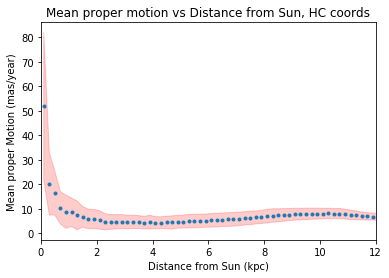

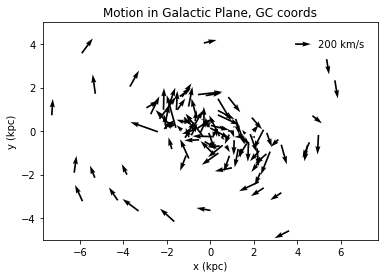

In [7]:
plot_pm(HCx, HCy, HCz, HCxvel, HCyvel, HCzvel, 0.2)
plot_cartesian_quiver(GCx, GCy, GCxvel, GCyvel, 1000, 5)

Number of stars: 15586


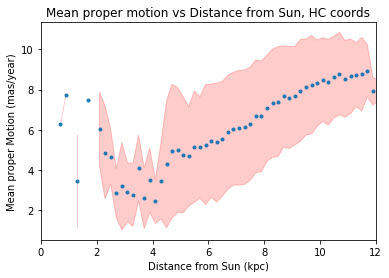

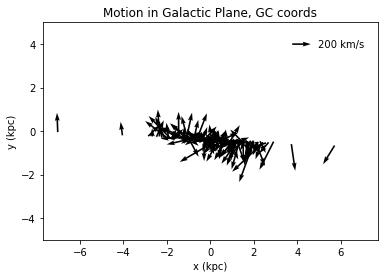

In [8]:
plot_pm(HCxOGLE, HCyOGLE, HCzOGLE, HCxvelOGLE, HCyvelOGLE, HCzvelOGLE, 0.2)
plot_cartesian_quiver(GCxOGLE, GCyOGLE, GCxvelOGLE, GCyvelOGLE, 100, 5)